# VAE for Smaller Circles

This notebook is the definition and the training of the VAE that predicts PI and the point clouds for the square or circle dataset.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from time import time

## Load the data 

In [6]:
data = np.load('../data/PI_data_smaller_circle_density.npz')

PC_train = data["data_train"]
PI_train = data["PI_train"]
density_train = data["density_train"]
PC_test = data["data_test"]
PI_test = data["PI_test"]
density_test = data["density_test"]

In [7]:
N_sets_train = PC_train.shape[0]
N_sets_test = PC_test.shape[0]
N_points = PC_train.shape[1]
PI_size = int(np.sqrt(PI_train.shape[1]))
size = int(np.sqrt(density_test.shape[1]))
dim = 2
batch_size = 64

In [8]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("N_points : ", N_points)
print("PI_size : ", PI_size)
print("Size : ", size)

N_sets_train :  9999
N_sets_test :  999
N_points :  500
PI_size :  50
Size :  50


We normalize the PIs and the densities.


In [9]:
PI_train /= max(np.max(PI_train), np.max(PI_test))
PI_test /= max(np.max(PI_test), np.max(PI_test))

In [10]:
for i in range(N_sets_train):
    density_train[i] /= np.max(density_train[i])
for i in range(N_sets_test):
    density_test[i] /= np.max(density_test[i])

We create random batchs. Each batch is an array of array that contains $(PI,PC)$.

In [11]:
data_train = np.stack((PI_train, density_train), 1)
data_test = np.stack((PI_test, density_test), 1)

In [12]:
train_dataset = (tf.data.Dataset.from_tensor_slices(
    np.float32(data_train)).shuffle(N_sets_train).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(
    np.float32(data_test)).shuffle(N_sets_test).batch(batch_size))

2021-07-15 09:47:26.379030: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-15 09:47:26.691457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-15 09:47:26.691974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-07-15 09:47:26.692038: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-15 09:47:26.692419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No suc

## Create the VAE

This sections defines the VAE *via* multiple classes. 

In [59]:
class Sampling(tf.keras.layers.Layer):
    """Uses (mean_joint, var_joint) to sample z_joint, the latent vector encoding the output."""
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + z_var * epsilon


class Encoder_PI(tf.keras.layers.Layer):
    """Maps the PI of the input to a couple (z_mean, z_log_var)."""
    def __init__(self, latent_dim=2, name="encoder_PI", **kwargs):
        super(Encoder_PI, self).__init__(name=name, **kwargs)

        self.dense_100 = tf.keras.layers.Dense(100, activation='sigmoid')
        self.dense_50 = tf.keras.layers.Dense(50, activation='sigmoid')

        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_var = tf.keras.layers.Dense(
            latent_dim)  #, activation='relu')

    def call(self, inputs):
        x = self.dense_100(inputs)
        x = self.dense_50(x)
        z_mean = self.dense_mean(x)
        z_var = self.dense_var(x)

        return z_mean, z_var


class Encoder_PC(tf.keras.layers.Layer):
    """Maps the PC of the input to a couple (z_mean, z_log_var)."""
    def __init__(self, latent_dim=2, name="encoder_PC", **kwargs):
        super(Encoder_PC, self).__init__(name=name, **kwargs)

        self.dense_100 = tf.keras.layers.Dense(100, activation='relu')
        self.dense_50 = tf.keras.layers.Dense(50, activation='relu')

        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_var = tf.keras.layers.Dense(
            latent_dim)  #, activation='relu')

    def call(self, inputs):
        x = self.dense_100(inputs)
        x = self.dense_50(x)
        z_mean = self.dense_mean(x)
        z_var = self.dense_var(x)

        return z_mean, z_var


class Shared_Decoder(tf.keras.layers.Layer):
    """Converts z_joint, the encoded vector, back into a couple (z_joint_PI,z_joint_PC)."""
    def __init__(self, latent_dim, name="shared_decoder", **kwargs):
        super(Shared_Decoder, self).__init__(name=name, **kwargs)
        self.dense_20 = tf.keras.layers.Dense(20)  #, activation='relu')
        self.dense_output = tf.keras.layers.Dense(
            latent_dim + latent_dim)  #,activation='sigmoid')

    def call(self, inputs):
        x = self.dense_20(inputs)
        return self.dense_output(x)
    
    
    
    
class Decoder_PI(tf.keras.layers.Layer):
    """Converts z_joint_PI, the encoded vector, back into a readable PI."""
    def __init__(self, original_dim, name="decoder_PI", **kwargs):
        super(Decoder_PI, self).__init__(name=name, **kwargs)
        self.dense_100 = tf.keras.layers.Dense(100)  #, activation='relu')
        self.dense_200 = tf.keras.layers.Dense(200)  #, activation='relu')

        self.dense_output = tf.keras.layers.Dense(original_dim)

    def call(self, inputs):
        x = self.dense_100(inputs)
        x = self.dense_200(x)
        return self.dense_output(x)



class Decoder_PC(tf.keras.layers.Layer):
    """Converts z_joint_PC, the encoded vector, back into a readable PC."""
    def __init__(self, original_dim, name="decoder_PC", **kwargs):
        super(Decoder_PC, self).__init__(name=name, **kwargs)
        self.dense_100 = tf.keras.layers.Dense(100)  #, activation='relu')
        self.dense_200 = tf.keras.layers.Dense(200)  #, activation='relu')
        self.dense_output = tf.keras.layers.Dense(
            original_dim)  #,activation='sigmoid')

    def call(self, inputs):
        x = self.dense_100(inputs)
        x = self.dense_200(x)

        return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 original_dim,
                 latent_dim=2,
                 name="autoencoder",
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder_PI = Encoder_PI(latent_dim=latent_dim)
        self.decoder_PI = Decoder_PI(original_dim)

        self.encoder_PC = Encoder_PC(latent_dim=latent_dim)
        self.decoder_PC = Decoder_PC(original_dim)

        self.sampling = Sampling()

        self.shared_decoder = Shared_Decoder(latent_dim)

    def call(self, inputs):
        PI_inputs, PC_inputs = inputs

        #First step, we encode the PI and PC we have in input
        z_mean_PI, z_var_PI = self.encoder_PI(PI_inputs)
        z_mean_PC, z_var_PC = self.encoder_PC(PC_inputs)

        #We then compute (mean_joint, var_joint) by doing a product of gaussians
        mean_joint = (z_mean_PI / z_var_PI +
                      z_mean_PC / z_var_PC) * (1 + 1 / z_var_PI + 1 / z_var_PC)
        var_joint = (1 + 1 / z_var_PI + 1 / z_var_PC)

        #We sample grom the joint distribution 
        z_joint = self.sampling((mean_joint, var_joint))
   

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            tf.math.log(tf.square(var_joint)) - tf.square(mean_joint) -
            tf.square(var_joint) + 1, 0)

        self.add_loss(tf.reduce_sum(kl_loss))

        #We decode z_joint into z_PI, z_PC
        z_PI, z_PC = tf.split(self.shared_decoder(z_joint),
                              num_or_size_splits=2,
                              axis=1)

        #We decode z_PI, z_PC into real PI and PC
        reconstructed_PI = self.decoder_PI(z_PI)
        reconstructed_PC = self.decoder_PC(z_PC)

        return reconstructed_PI, reconstructed_PC

In [66]:
original_dim = PI_size * PI_size
latent_dim = 2
vae = VariationalAutoEncoder(original_dim, latent_dim)

optimizer = tf.keras.optimizers.Adamax(learning_rate=5e-2)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

#We keep track of the losses
mse_loss_PI = []
mse_loss_PC = []
kl_loss = []

#Number of epochs
epochs = 100

# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch + 1, ))
    initial_time = time()
    
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        #For each batch, we separate the PI from the PC
        PI_inputs = x_batch_train[:, 0, :]
        PC_inputs = x_batch_train[:, 1, :]
        with tf.GradientTape() as tape:
            reconstructed_PI, reconstructed_PC = vae((PI_inputs, PC_inputs))
            
            # Compute reconstruction loss with hyperparameters
            loss = 10*mse_loss_fn(x_batch_train[:, 0, :], reconstructed_PI)
            loss += 10*mse_loss_fn(x_batch_train[:, 1, :], reconstructed_PC)

            loss += tf.reduce_sum(vae.losses)  # Add KLD regularization loss
 
        # Compute the gradient          
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        # Keep track of the losses
        mse_loss_PI.append(
            mse_loss_fn(x_batch_train[:, 0, :], reconstructed_PI))
        mse_loss_PC.append(
            mse_loss_fn(x_batch_train[:, 1, :], reconstructed_PC))
        kl_loss.append(vae.losses[0])

    print(
        "Epoch %d: MSE loss for PI = %.4e, MSE loss for PC = %.4e, KL loss = %.4e"
        % (epoch + 1, mse_loss_fn(x_batch_train[:, 0, :],
                                  reconstructed_PI).numpy(),
           mse_loss_fn(x_batch_train[:, 1, :],
                       reconstructed_PC).numpy(), vae.losses[0].numpy()))

    print("Time to compute epoch {} : {} sec".format(epoch + 1,
                                                     time() - initial_time))

Start of epoch 1
Epoch 1: MSE loss for PI = 1.5467e+00, MSE loss for PC = 9.4014e+00, KL loss = 8.2234e-01
Time to compute epoch 1 : 6.107912063598633 sec
Start of epoch 2
Epoch 2: MSE loss for PI = 1.9016e+00, MSE loss for PC = 1.8972e+00, KL loss = 8.0198e-01
Time to compute epoch 2 : 6.207485675811768 sec
Start of epoch 3
Epoch 3: MSE loss for PI = 1.9299e+00, MSE loss for PC = 6.4246e-01, KL loss = 7.6893e-01
Time to compute epoch 3 : 6.526245355606079 sec
Start of epoch 4
Epoch 4: MSE loss for PI = 2.6633e+00, MSE loss for PC = 1.7116e-01, KL loss = 7.3918e-01
Time to compute epoch 4 : 6.928826570510864 sec
Start of epoch 5
Epoch 5: MSE loss for PI = 2.0496e+00, MSE loss for PC = 7.8368e-02, KL loss = 7.0094e-01
Time to compute epoch 5 : 6.6267406940460205 sec
Start of epoch 6
Epoch 6: MSE loss for PI = 1.6717e+00, MSE loss for PC = 6.5125e-02, KL loss = 6.5038e-01
Time to compute epoch 6 : 6.3198628425598145 sec
Start of epoch 7
Epoch 7: MSE loss for PI = 1.7466e+00, MSE loss for

Epoch 53: MSE loss for PI = 3.3684e-03, MSE loss for PC = 6.0164e-02, KL loss = 4.2484e-02
Time to compute epoch 53 : 5.9615395069122314 sec
Start of epoch 54
Epoch 54: MSE loss for PI = 3.0420e-02, MSE loss for PC = 5.9069e-02, KL loss = 3.8662e-02
Time to compute epoch 54 : 5.958548545837402 sec
Start of epoch 55
Epoch 55: MSE loss for PI = 4.5818e-03, MSE loss for PC = 6.9381e-02, KL loss = 4.1209e-02
Time to compute epoch 55 : 5.936791181564331 sec
Start of epoch 56
Epoch 56: MSE loss for PI = 4.3628e-03, MSE loss for PC = 8.4153e-02, KL loss = 4.0834e-02
Time to compute epoch 56 : 5.968998908996582 sec
Start of epoch 57
Epoch 57: MSE loss for PI = 9.3600e-03, MSE loss for PC = 5.5223e-02, KL loss = 3.7551e-02
Time to compute epoch 57 : 5.951002597808838 sec
Start of epoch 58
Epoch 58: MSE loss for PI = 1.7780e-03, MSE loss for PC = 4.7826e-02, KL loss = 3.4810e-02
Time to compute epoch 58 : 6.139059543609619 sec
Start of epoch 59
Epoch 59: MSE loss for PI = 2.6713e-03, MSE loss fo

KeyboardInterrupt: 

We can plot the evolution of the errors

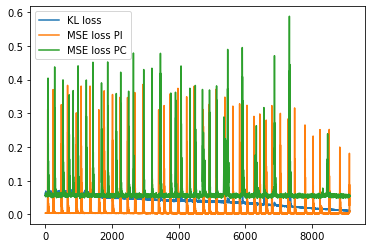

In [69]:
i = 4000
plt.plot(kl_loss[i:])
plt.plot(mse_loss_PI[i:])
plt.plot(mse_loss_PC[i:])
plt.legend(["KL loss", "MSE loss PI", "MSE loss PC"])

(array([ 39., 187.,   5.,  19.,  10.,  11., 154., 194.,  30., 350.]),
 array([0.98588806, 0.99602807, 1.006168  , 1.016308  , 1.026448  ,
        1.036588  , 1.0467279 , 1.0568678 , 1.0670078 , 1.0771478 ,
        1.0872878 ], dtype=float32),
 <a list of 10 Patch objects>)

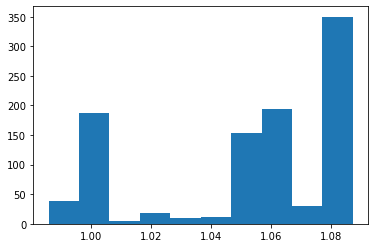

In [58]:
plt.hist(var_joint.numpy().flatten())

### Quick look at the results

We can plot the results of a test dataset to see have our VAE did.

In [70]:
PI_pred, PC_pred = vae((PI_test, density_test))

In [71]:
for i in range(4):
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(PI_pred[i+10], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(np.flip(np.reshape(PC_pred[i+10], [size, size]), 0), cmap='jet')
    #plt.colorbar()
    plt.axis('off')
#plt.savefig("Résultats/VAE_full_2_predicted.pdf")

Here are the real densities and the real PI.

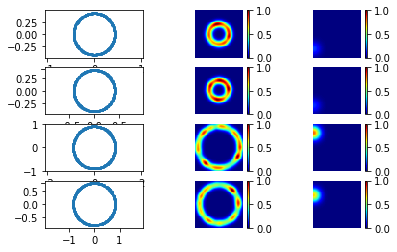

In [25]:
for i in range(4):
    plt.subplot(4, 3, 3 * i + 1)
    #PC = np.reshape(predictions[i, :dim * N_points], (N_points, dim))
    plt.scatter(PC_test[i+10, :, 0], PC_test[i+10, :, 1], s=3)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('equal')
    plt.subplot(4, 3, 3 * i + 2)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.flip(np.reshape(density_test[i+10], [size, size]), 0),
               cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(4, 3, 3 * i + 3)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.flip(np.reshape(PI_test[i+10], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()
    plt.axis('off')

#plt.savefig("Résultats/VAE_full_1_true.pdf")

We can save the VAE

In [77]:
vae.save('Saved_Model/VAE_full_2')

2021-07-12 16:49:49.001784: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Saved_Model/VAE_full_2/assets


INFO:tensorflow:Assets written to: Saved_Model/VAE_full_2/assets
